# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import patsy

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [34]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [35]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [36]:
current_event = 30
element_types = [1, 2, 3]
threshold_minutes = 1

In [37]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [38]:
element_gameweek_df['clean_sheets_no_time'] =\
element_gameweek_df['goals_conceded'].apply(lambda x: 1 if x == 0 else 0)

# Models

## Bernoulli teams model

### Preparing data

In [39]:
btm_df = element_gameweek_df.copy()

In [40]:
btm_formula = 'clean_sheets_no_time ~ C(opposition_team) + C(own_team)'

btm_response_df, btm_explanatory_df = patsy.dmatrices(btm_formula, btm_df, return_type='dataframe')

### Fitting model

In [41]:
btm_results = sm.GLM(
    btm_response_df,
    btm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [42]:
print(btm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 6985
Model:                              GLM   Df Residuals:                     6946
Model Family:                  Binomial   Df Model:                           38
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -4144.3
Date:                  Sat, 23 Mar 2019   Deviance:                       8288.7
Time:                          16:22:36   Pearson chi2:                 6.98e+03
No. Iterations:                       4                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.9273      0.192    -10.038      0.000      -2.304     

### Model fit

In [43]:
btm_results.aic

8366.689508217783

In [44]:
btm_results.bic

-53193.970298948334

In [45]:
btm_pearson_results = goodness_fit.pearson_chi_squared_test(btm_results)
btm_pearson_results

(False, 0.39744704345583903)

In [46]:
btm_results.resid_deviance.describe()

count    6985.000000
mean       -0.083157
std         1.086230
min        -1.790021
25%        -0.920625
50%        -0.647534
75%         1.144107
max         2.348161
dtype: float64

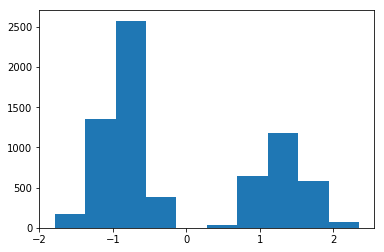

In [47]:
plt.figure()
plt.hist(btm_results.resid_deviance)
plt.show()

## Bernoulli teams minutes model

### Preparing data

In [110]:
btmm_df = element_gameweek_df.copy()

In [129]:
btmm_formula = 'clean_sheets_no_time ~ minutes + C(opposition_team) + C(own_team)'

btmm_response_df, btmm_explanatory_df = patsy.dmatrices(btmm_formula, btmm_df, return_type='dataframe')

### Fitting model

In [130]:
btmm_results = sm.GLM(
    btmm_response_df,
    btmm_explanatory_df,
    family=sm.families.Binomial(),
    missing='drop'
).fit()

In [131]:
print(btmm_results.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     clean_sheets_no_time   No. Observations:                 6985
Model:                              GLM   Df Residuals:                     6945
Model Family:                  Binomial   Df Model:                           39
Link Function:                    logit   Scale:                             1.0
Method:                            IRLS   Log-Likelihood:                -3741.1
Date:                  Sat, 23 Mar 2019   Deviance:                       7482.2
Time:                          16:29:36   Pearson chi2:                 6.83e+03
No. Iterations:                       5                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0436      0.215     -0.203      0.839      -0.465     

### Model fit

In [132]:
btmm_results.aic

7562.236546868067

In [133]:
btmm_results.bic

-53991.57174002635

In [134]:
btmm_pearson_results = goodness_fit.pearson_chi_squared_test(btmm_results)
btmm_pearson_results

(False, 0.8451566253656166)

In [135]:
btmm_results.resid_deviance.describe()

count    6985.000000
mean       -0.079988
std         1.031960
min        -2.512010
25%        -0.823552
50%        -0.519472
75%         0.954085
max         2.356799
dtype: float64

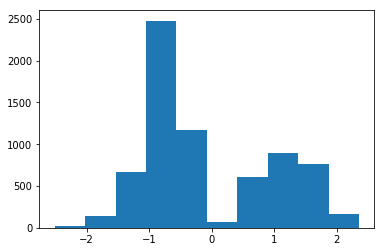

In [136]:
plt.figure()
plt.hist(btmm_results.resid_deviance)
plt.show()

# Model comparison

In [137]:
{
    'Bernoulli teams': btm_results.aic,
    'Bernoulli teams minutes': btmm_results.aic,
}

{'Bernoulli teams': 8366.689508217783,
 'Bernoulli teams minutes': 7562.236546868067}

AIC prefers...

In [138]:
{
    'Bernoulli teams': btm_results.bic,
    'Bernoulli teams minutes': btmm_results.bic,
}

{'Bernoulli teams': -53193.970298948334,
 'Bernoulli teams minutes': -53991.57174002635}

BIC prefers...

In [139]:
{
    'Bernoulli teams': btm_pearson_results,
    'Bernoulli teams minutes': btmm_pearson_results,
}

{'Bernoulli teams': (False, 0.39744704345583903),
 'Bernoulli teams minutes': (False, 0.8451566253656166)}

... fit